# **データ同化の基礎 カルマンフィルターのPythonプログラム**


## **問題設定**
ここでは, 1次元座標上で質量$m$の質点がバネとダッシュポットに繋がれた「減衰項つきの振動モデル」を例として, **カルマンフィルター（Kalman Filter; KF)**のプログラムを解説します. この減衰項つきの振動モデルは, 次式で表されます.

*  質点の運動方程式: $m\frac{dv}{dt}=-kx-rv$
*  質点の速度: $v=\frac{dx}{dt}$

ここで, $k$はバネ定数, $r$はダッシュポットの減衰係数です.

上記の振動モデルは, 時間を前進差分法（オイラー法）で離散化($\frac{dx}{dt}\simeq\frac{x_t-x_{t-1}}{\Delta t}$)すると, 次式のように表されます.

$x_t = x_{t-1} + \Delta t v_{t-1}$

$v_t = -\left(\frac{k\Delta t}{m}\right)x_{t-1}+\left(1-\frac{r\Delta t}{m}\right)v_{t-1}$

よって, 時刻$t$における状態ベクトルを$\mathbf{x}_t = \left(x_t, v_t\right)^{T}$と表せば, 状態の変化は,

$\mathbf{x}_t = \mathbf{M}\mathbf{x}_{t-1}$

と記述できます. ここで, $\mathbf{M}$は**状態遷移行列**と呼び, この問題の場合には次式で表されます.

\begin{equation}
\mathbf{M}=
\begin{bmatrix}
   1 & \Delta t \\
   -k\Delta t/m & 1-r\Delta t/m
\end{bmatrix}
\end{equation}

*カルマンフィルターは, 状態$\mathbf{x}_t$の変化が上式のように**線形で表される場合にのみ適用できます**.*

以下では, この振動モデルに対してカルマンフィルタを適用してみましょう.

## **カルマンフィルターの式**
カルマンフィルターなどのフィルター系の逐次データ同化は, 系の状態変化を表すモデルを用いて, **系の状態とその誤差共分散の時間発展を計算**する**「予測ステップ」**と系の状態の予測結果と誤差共分散を修正する**「フィルタリングステップ」**の2ステップに分類できます.

以下では, 予測ステップで計算した状態や誤差共分散には, 上付き添字の$f$(forecastの頭文字)を付け, フィルタリングステップで計算したものには上付き添字の$a$(analysisの頭文字)をつけることとします.

このとき, カルマンフィルターでは次式を順次計算していきます.

**予測ステップ**
*  系の状態変化の予測: $\mathbf{x}_t^f=\mathbf{M}\mathbf{x}_{t-1}^f$
*  予測誤差共分散行列の変化（リヤプノフ方程式)の計算: $\mathbf{P}_t^f=\mathbf{M}\mathbf{P}_{t-1}^f\mathbf{M}^\mathsf{T}+\mathbf{Q}$

ここで, $\mathbf{Q}$はシステムノイズの共分散行列を表します.

**フィルタリングステップ**
*  予測した系の状態変化の修正: $\mathbf{x}_t^a=\mathbf{x}_t^f+\mathbf{K}_t(\mathbf{y}_t-\mathbf{H}_t\mathbf{x}_t^f)$
*  カルマンゲインの計算: $\mathbf{K}_t=\mathbf{P}_t^f\mathbf{H}_t^\mathsf{T}(\mathbf{R}_t+\mathbf{H}_t\mathbf{P}_t^f\mathbf{H}_t^\mathsf{T})^{-1}$
*  解析誤差共分散行列の計算: $\mathbf{P}_t^a=(\mathbf{I}-\mathbf{K}_t\mathbf{H}_t)\mathbf{P}_t^f$

ここで, $\mathbf{y}_t$は観測ベクトルと呼ばれ, 観測データが保存されたベクトル量です. $\mathbf{H}_t$は観測行列と呼ばれ, 状態ベクトル$\mathbf{x}_t$から観測ベクトルと比較できる部分だけを取り出す作用をします. $\mathbf{R}_t$は観測誤差共分散行列を表します.

## **カルマンフィルターのプログラミング**
それでは, 以下にカルマンフィルターのプログラムを示していきましょう.

ソースコードの中にコメントとして, 各行の説明を記載しています.
### **ライブラリのインポート**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### **計算条件等の設定**
このプログラムでは, 時間増分を0.01として, 全部で1400ステップの増分計算を行います. そのうち, 最初の400ステップでは観測データを同化しながら, 振動モデルを用いた状態予測を行います. 後半の1000ステップでは, データ同化を行わずに状態予測を行います.

In [ ]:
nt_asm = 400 # データ同化を実施する間のステップ数
nt_prd = 1000 # データ同化したモデルを使って予測を行うステップ数
obs_interval = 80 # データ同化を行うステップ間隔
mass = 1.0 # 質量
k = 0.5 # バネ定数
dump = 0.3 # 減衰定数
dt = 0.01 # 時間増分
pi = 3.14159265358979 # 円周率

### **配列の確保とゼロリセット**
各配列の説明は, コメントを参照してください.

In [ ]:
x_t = np.zeros((nt_asm+nt_prd)) # 質点の位置(真値)
v_t = np.zeros((nt_asm+nt_prd)) # 質点の速度(真値)
x_s = np.zeros((nt_asm+nt_prd)) # 質点の位置(シミュレーション結果 without データ同化)
v_s = np.zeros((nt_asm+nt_prd)) # 質点の速度(シミュレーション結果 without データ同化)
x_da = np.zeros((nt_asm+nt_prd)) # 質点の位置(シミュレーション結果 with データ同化)
v_da = np.zeros((nt_asm+nt_prd)) # 質点の速度(シミュレーション結果 with データ同化)
x_obs = np.zeros((int(nt_asm/obs_interval)+1)) # 観測データとして用いる質点の位置(観測データ)
time = np.zeros((nt_asm+nt_prd))
time_obs = np.zeros((int(nt_asm/obs_interval)+1))
obs_chr = np.zeros((nt_asm))
M = np.zeros((2,2)) # 状態遷移行列
Pf = np.zeros((2,2)) # 予測誤差共分散行列
Pa = np.zeros((2,2)) # 解析誤差共分散行列
R = np.zeros((1,1)) # 観測誤差共分散行列
Kg = np.zeros((2,1)) # カルマンゲイン
H = np.zeros((1,2)) # 観測行列
Ptmp = np.zeros((2,2)) # 予測誤差共分散の時間発展を計算するときに使用する配列

### **状態の初期状態設定**
このプログラムでは, 「観測データ = 真の状態 + 誤差」であるとします. よって, カルマンフィルタにより, 「真の状態」を予測できることを目指します. このプログラムにおいては,

* 真の状態: 質点の初期位置$x_0 = 5$, 初期速度$v_0 = 0$
* 初期推定: 質点の初期位置$x_0 = 10$, 初期速度$v_0 = 5$
* 観測誤差共分散行列:   
\begin{equation}
\mathbf{R}_0=
\begin{bmatrix}
   0.5 & 0 \\
   0 & 0
\end{bmatrix}
\end{equation}
つまり, 質点の初期位置の観測誤差（分散）が0.5を意味します.
* 観測行列:
\begin{equation}
\mathbf{H}_t=
\begin{bmatrix}
   1 & 0 \\
   0 & 0
\end{bmatrix}
\end{equation}
つまり, 質点の位置だけが観測データとして得られることを想定しています.

In [ ]:
x_t[0]=5.0 # 質点の初期位置の真値
v_t[0]=0.0 # 質点の初期速度の真値
x_s[0]=10.0 # 質点の初期位置の初期推定値
v_s[0]=5.0 # 質点の初期速度の初期推定値
Pf[0,0]=1.0
Pf[0,1]=0.0
Pf[1,0]=0.0
Pf[1,1]=1.0
Pa=Pf
R[0,0]=0.5 # 質点の初期位置の観測誤差
Kg[0:1,0:1]=0.0
H[0,0]=1.0
H[0,1]=0.0

### **状態遷移行列の設定**
状態遷移行列
\begin{equation}
\mathbf{M}=
\begin{bmatrix}
   1 & \Delta t \\
   -k\Delta t/m & 1-r\Delta t/m
\end{bmatrix}
\end{equation}を設定します.

In [ ]:
M[0,0] = 1.0
M[0,1] = dt
M[1,0] = -k * dt/ mass
M[1,1] = 1.0 - dump * dt / mass

### **観測データの作成**
質点の位置だけが観測データとして利用できることを想定します.
真の初期状態を用いて、

$x_t = x_{t-1} + \Delta t v_{t-1}$

$v_t = -\left(\frac{k\Delta t}{m}\right)x_{t-1}+\left(1-\frac{r\Delta t}{m}\right)v_{t-1}$

を計算します.

観測データ（質点の位置）は, 時刻0 ~ 4.0の間で80ステップごとにしか得られず, さらにそれにはノイズが載っていることを想定しています.

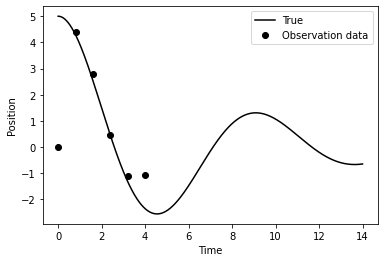

In [ ]:
for it in range(1,nt_asm+nt_prd):
    time[it] = it*dt
    x_t[it] = x_t[it-1] + dt * v_t[it-1]
    v_t[it] = -(k * dt / mass) * x_t[it-1] + (1.0 - dump * dt / mass) * v_t[it-1]

    if (it % obs_interval == 0) & (it <= nt_asm):
      time_obs[int(it/obs_interval)] = it*dt
      noise1 = np.random.rand(1)
      noise2 = np.random.rand(1)
      gnoise = np.sqrt(R[0,0])*np.sqrt(-2.0*np.log(1.0-noise1))*np.cos(2.0*pi*noise2)
      x_obs[int(it/obs_interval)] = x_t[it]+gnoise

plt.plot(time, x_t, '-', color="k", label="True")
plt.plot(time_obs, x_obs, 'o', color="k", label="Observation data")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()
plt.show()

### **データ同化を行わずにシミュレーションを実施**
この計算結果は, 真値から乖離することは明らかであるが, カルマンフィルターの計算結果の比較対象として計算します.

In [ ]:
for it in range(1,nt_asm+nt_prd):
    x_s[it] = x_s[it-1] + dt * v_s[it-1]
    v_s[it] = -(k * dt / mass) * x_s[it-1] + (1.0 - dump * dt / mass) * v_s[it-1]

### **データ同化を行いながらシミュレーションを実施**
ここで, 計算しているのは,

**予測ステップ**
*  系の状態変化の予測: $\mathbf{x}_t^f=\mathbf{M}\mathbf{x}_{t-1}^f$
*  予測誤差共分散行列の変化（リヤプノフ方程式)の計算: $\mathbf{P}_t^f=\mathbf{M}\mathbf{P}_{t-1}^f\mathbf{M}^\mathsf{T}+\mathbf{Q}$

**フィルタリングステップ**
*  予測した系の状態変化の修正: $\mathbf{x}_t^a=\mathbf{x}_t^f+\mathbf{K}_t(\mathbf{y}_t-\mathbf{H}_t\mathbf{x}_t^f)$
*  カルマンゲインの計算: $\mathbf{K}_t=\mathbf{P}_t^f\mathbf{H}_t^\mathsf{T}(\mathbf{R}_t+\mathbf{H}_t\mathbf{P}_t^f\mathbf{H}_t^\mathsf{T})^{-1}$
*  解析誤差共分散行列の計算: $\mathbf{P}_t^a=(\mathbf{I}-\mathbf{K}_t\mathbf{H}_t)\mathbf{P}_t^f$

です.


In [ ]:
x_da[0] = x_s[0]
v_da[0] = v_s[0]

for it in range(1,nt_asm):

    #--- 予測ステップ
    #--- シミュレーションモデルで状態予測
    x_da[it] = x_da[it-1] + dt * v_da[it-1]
    v_da[it] = -(k * dt / mass) * x_da[it-1] + (1.0 - dump * dt / mass) * v_da[it-1]
    #--- リヤプノフ方程式に基づき予測誤差共分散行列を計算
    Ptmp = M.T # 状態遷移行列の転置
    Ptmp = np.dot(Pf,Ptmp)
    Pf = np.dot(M,Ptmp)    # 予測誤差共分散行列の時間発展

    #--- フィルタリングステップ
    #--- 観測データを同化する時刻ではカルマンフィルターに基づき状態と共分散行列の修正
    if it % obs_interval == 0:
        #--- カルマンゲインを計算
        Kg[0,0] = Pf[0,0]/(R[0,0]+Pf[0,0])
        Kg[1,0] = Pf[1,0]/(R[0,0]+Pf[0,0])
        #--- 状態変数を修正する
        x_innov = x_obs[int(it/obs_interval)] - x_da[it]
        x_da[it] = x_da[it] + Kg[0,0]*x_innov
        v_da[it] = v_da[it] + Kg[1,0]*x_innov
        #--- 予測誤差共分散行列を修正して解析誤差共分散行列を計算
        Pa = Pf - np.dot(np.dot(Kg,H),Pf)
        Pf = Pa

### **データ同化した結果を用いて, その後を予測する**

In [ ]:
for it in range(nt_asm,nt_asm+nt_prd):
    x_da[it] = x_da[it-1] + dt * v_da[it-1]
    v_da[it] = -(k * dt / mass) * x_da[it-1] + (1.0 - dump * dt / mass) * v_da[it-1]

### **データ同化の結果を可視化**
**質点の位置の変化**

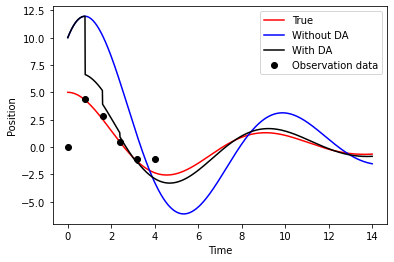

In [ ]:
plt.plot(time, x_t, '-', color="r", label="True")
plt.plot(time, x_s, '-', color="b", label="Without DA")
plt.plot(time, x_da, '-', color="k", label="With DA")
plt.plot(time_obs, x_obs, 'o', color="k", label="Observation data")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()
plt.show()

**質点の速度の変化**

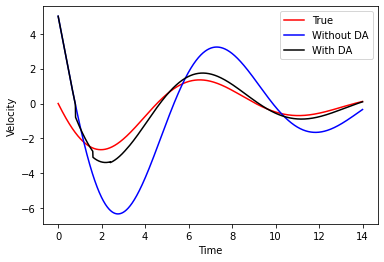

In [ ]:
plt.plot(time, v_t, '-', color="r", label="True")
plt.plot(time, v_s, '-', color="b", label="Without DA")
plt.plot(time, v_da, '-', color="k", label="With DA")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()
plt.show()

## **参考文献**
淡路敏之, 蒲地政文, 池田元美, 石川洋一, データ同化 観測・実験とモデルを融合するイノベーション, 京都大学学術出版会, (2009)